In [18]:
# Install required packages.
from functools import partial 
import os
import torch
import time
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# %pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# %pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# %pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from ray import tune
from ray.air import session
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
# from hyperopt import hp
# from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search.basic_variant import BasicVariantGenerator

1.12.1+cpu


In [2]:
def set_seed(seed: int = 42) -> None:
    # np.random.seed(seed)
    # random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [4]:
def visualize(h, filename, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    plt.savefig(filename)

def load_dataset(name):
    '''
    name: Cora, Citeseer
    '''
    dataset = Planetoid(root='data/Planetoid', name=name, transform=NormalizeFeatures())

    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')

    data = dataset[0]  # Get the first graph object.

    print()
    print(data)
    print('===========================================================================================================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

    return dataset, data 

# Cora dataset 

In [5]:
dataset, data = load_dataset('Cora')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [6]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, p1, p2, activation):
        super().__init__()
        self.p1 = p1
        self.p2 = p2
        self.activation = F.relu
        if activation == 'elu':
            self.activation = F.elu
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.p1, training=self.training)
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = F.dropout(x, p=self.p2, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [7]:
def train(gcn, optimizer, criterion):
    gcn.train()
    optimizer.zero_grad()  # Clear gradients.
    out = gcn(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def validate(gcn, criterion):
    gcn.eval()
    out = gcn(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    return val_loss.item()

def test(gcn, criterion):
    gcn.eval()
    out = gcn(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc
    

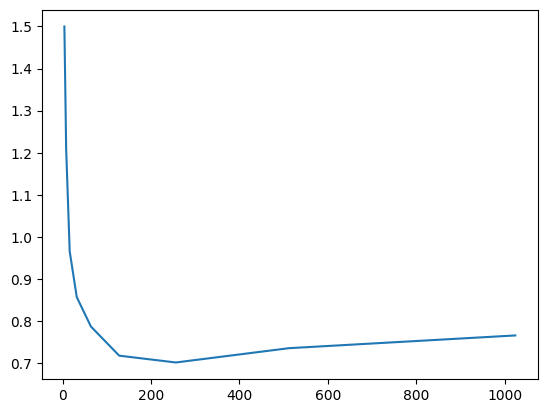

In [8]:
# Check for suitable range for hidden_channels
hiddenchannels_candidates = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
val_loss = []
for i in hiddenchannels_candidates:
    gcn = GCN(hidden_channels=i, p1=0.6, p2=0.6, activation='elu')
    optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_loss = train(gcn, optimizer, criterion)
    best_loss = validate(gcn, criterion)
    torch.save(gcn, 'best_model_hidden_channels.pt')
    for epoch in range(100):
        train_loss = train(gcn, optimizer, criterion)
        validate_loss = validate(gcn, criterion)
        if abs(validate_loss) < abs(best_loss):
            torch.save(gcn, 'best_model_hidden_channels.pt')
    gcn = torch.load('best_model_hidden_channels.pt')
    gcn.eval()
    val_loss.append(validate(gcn, criterion))

plt.plot(hiddenchannels_candidates, val_loss)
plt.show()

We want to minimise the validation loss. Hence, it seems like number of hidden channels 128 and 256 are good candidates for our parameter space

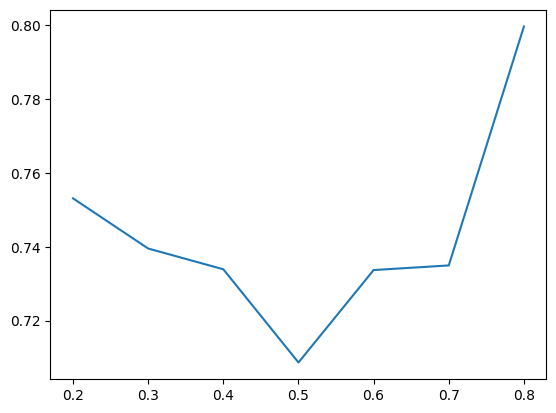

In [9]:
# Check for suitable range for p1
p1_candidates = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
val_loss = []
for i in p1_candidates:
    gcn = GCN(hidden_channels=128, p1=i, p2=0.6, activation='elu')
    optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_loss = train(gcn, optimizer, criterion)
    best_loss = validate(gcn, criterion)
    torch.save(gcn, 'best_model_p1.pt')
    for epoch in range(100):
        train_loss = train(gcn, optimizer, criterion)
        validate_loss = validate(gcn, criterion)
        if abs(validate_loss) < abs(best_loss):
            torch.save(gcn, 'best_model_p1.pt')
    gcn = torch.load('best_model_p1.pt')
    gcn.eval()
    val_loss.append(validate(gcn, criterion))

plt.plot(p1_candidates, val_loss)
plt.show()

p1 should be between 0.4 to 0.6

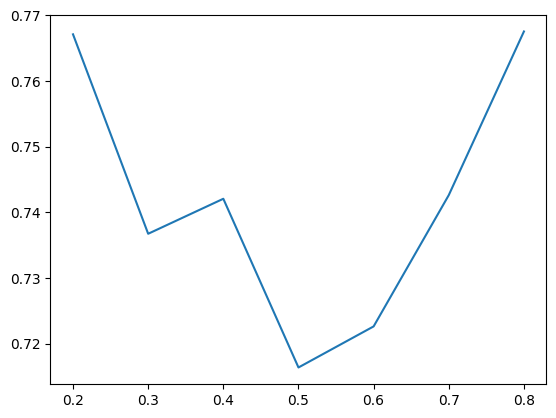

In [11]:
# Check for suitable range for p2
p2_candidates = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
val_loss = []
for i in p2_candidates:
    gcn = GCN(hidden_channels=128, p1=0.6, p2=i, activation='elu')
    optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_loss = train(gcn, optimizer, criterion)
    best_loss = validate(gcn, criterion)
    torch.save(gcn, 'best_model_p2.pt')
    for epoch in range(100):
        train_loss = train(gcn, optimizer, criterion)
        validate_loss = validate(gcn, criterion)
        if abs(validate_loss) < abs(best_loss):
            torch.save(gcn, 'best_model_p2.pt')
    gcn = torch.load('best_model_p2.pt')
    gcn.eval()
    val_loss.append(validate(gcn, criterion))

plt.plot(p2_candidates, val_loss)
plt.show()

p2 should be between 0.4 to 0.6

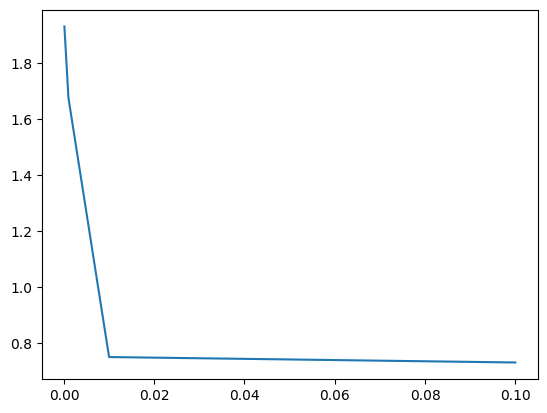

In [12]:
# Check for suitable range for learning rate
lr_candidates = [0.0001, 0.001, 0.01, 0.1]
val_loss = []
for i in lr_candidates:
    gcn = GCN(hidden_channels=128, p1=0.6, p2=0.6, activation='elu')
    optimizer = torch.optim.Adam(gcn.parameters(), lr=i, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_loss = train(gcn, optimizer, criterion)
    best_loss = validate(gcn, criterion)
    torch.save(gcn, 'best_model_lr.pt')
    for epoch in range(100):
        train_loss = train(gcn, optimizer, criterion)
        validate_loss = validate(gcn, criterion)
        if abs(validate_loss) < abs(best_loss):
            torch.save(gcn, 'best_model_lr.pt')
    gcn = torch.load('best_model_lr.pt')
    gcn.eval()
    val_loss.append(validate(gcn, criterion))

plt.plot(lr_candidates, val_loss)
plt.show()

lr from range of 0.01 to 0.1 seems good

## Model Tuning

In [15]:
def train_gcn(config):
    gcn = GCN(config['hidden_channels'], config['p1'], config['p2'], config['activation'])
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(gcn.parameters(), lr=config['lr'], weight_decay=5e-4)
    gcn.train()
    train_loss = train(gcn, optimizer, criterion)
    best_loss = validate(gcn, criterion)
    for epoch in range(100):
        train_loss = train(gcn, optimizer, criterion)
        validate_loss = validate(gcn, criterion)
        if abs(validate_loss) < abs(best_loss):
            best_loss = validate_loss
    session.report({'best_loss': validate_loss})
config = {
    'hidden_channels': tune.choice([128, 256]),
    'lr': tune.loguniform(1e-2, 1e-1),
    'p1': tune.quniform(0.4, 0.6, 0.1),
    'p2': tune.quniform(0.4, 0.6, 0.1),
    'activation': tune.choice(['relu', 'elu'])
}
tuner = tune.Tuner(
    train_gcn,
    tune_config=tune.TuneConfig(
        num_samples=100,
        mode='min',
        metric='best_loss'
    ),
    param_space=config
)

In [16]:
results = tuner.fit()

2022-10-14 23:59:09,244	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-14 23:59:14,458	WARNING function_trainable.py:619 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,activation,hidden_channels,lr,p1,p2,iter,total time (s),best_loss
train_gcn_26ec0_00000,TERMINATED,127.0.0.1:18328,elu,256,0.0595592,0.5,0.5,1,49.53,0.684279
train_gcn_26ec0_00001,TERMINATED,127.0.0.1:13120,elu,256,0.0220534,0.5,0.5,1,37.8044,0.721938
train_gcn_26ec0_00002,TERMINATED,127.0.0.1:8188,relu,256,0.0661832,0.4,0.5,1,26.9969,0.709913
train_gcn_26ec0_00003,TERMINATED,127.0.0.1:18220,elu,256,0.0488469,0.5,0.4,1,27.9937,0.729931
train_gcn_26ec0_00004,TERMINATED,127.0.0.1:21420,relu,128,0.0672568,0.5,0.4,1,14.8299,0.730609
train_gcn_26ec0_00005,TERMINATED,127.0.0.1:7644,elu,128,0.0990348,0.5,0.6,1,16.0056,0.719958
train_gcn_26ec0_00006,TERMINATED,127.0.0.1:19136,relu,256,0.0290521,0.5,0.5,1,35.1131,0.669119
train_gcn_26ec0_00007,TERMINATED,127.0.0.1:1700,elu,128,0.0984195,0.6,0.5,1,25.2908,0.720213
train_gcn_26ec0_00008,TERMINATED,127.0.0.1:13120,elu,256,0.0736861,0.5,0.4,1,47.3417,0.690224
train_gcn_26ec0_00009,TERMINATED,127.0.0.1:21420,relu,128,0.0204076,0.6,0.5,1,24.5623,0.725806


2022-10-14 23:59:38,010	WARNING worker.py:1829 -- Warning: The actor ImplicitFunc is very large (29 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-10-14 23:59:38,543	WARNING util.py:220 -- The `start_trial` operation took 3.005 s, which may be a performance bottleneck.
2022-10-14 23:59:55,775	WARNING util.py:220 -- The `start_trial` operation took 1.675 s, which may be a performance bottleneck.
2022-10-15 00:00:15,329	WARNING util.py:220 -- The `start_trial` operation took 1.517 s, which may be a performance bottleneck.
2022-10-15 00:00:29,315	WARNING util.py:220 -- The `start_trial` operation took 0.907 s, which may be a performance bottleneck.
2022-10-15 00:00:42,074	WARNING util.py:220 -- The `start_trial` operation took 0.751 s, which may be a performance bottleneck.
2022-10-15 00:00:49,849	WARNING util.py:220 -- The `start_trial` operation took 0.881 s, which 

Result for train_gcn_26ec0_00002:
  best_loss: 0.7099134922027588
  date: 2022-10-15_00-00-53
  done: false
  experiment_id: d23b0d8174d74216b65c2469d91c6b5e
  hostname: Jacintha
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 8188
  time_since_restore: 26.99685549736023
  time_this_iter_s: 26.99685549736023
  time_total_s: 26.99685549736023
  timestamp: 1665763253
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 26ec0_00002
  warmup_time: 0.015422582626342773
  
Result for train_gcn_26ec0_00001:
  best_loss: 0.7219381928443909
  date: 2022-10-15_00-00-48
  done: false
  experiment_id: dcbf4a7542fc453daac1923a66027372
  hostname: Jacintha
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 13120
  time_since_restore: 37.80439257621765
  time_this_iter_s: 37.80439257621765
  time_total_s: 37.80439257621765
  timestamp: 1665763248
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 26ec0_00001
  warmup_time: 0.013673067092895508
  
Result for 

2022-10-15 00:08:52,856	INFO tune.py:758 -- Total run time: 578.40 seconds (577.44 seconds for the tuning loop).


In [17]:
best_config = results.get_best_result(metric='best_loss', mode='min').config
best_config

{'hidden_channels': 256,
 'lr': 0.029052117825613778,
 'p1': 0.5,
 'p2': 0.5,
 'activation': 'relu'}

In [20]:
test_acc = []
train_time = []
seeds = [1, 12, 123, 1234, 12345, 123456, 1234567, 12345678, 123456789, 1234567890]
all_results = []
for seed in seeds:
    set_seed(seed)
    start = time.process_time()
    gcn = GCN(best_config['hidden_channels'], best_config['p1'], best_config['p2'], best_config['activation'])
    optimizer = torch.optim.Adam(gcn.parameters(), lr=best_config['lr'], weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    train_loss = train(gcn, optimizer, criterion)
    best_loss = validate(gcn, criterion)
    torch.save(gcn, 'best-model.pt')
    for epoch in range(100):
        train_loss = train(gcn, optimizer, criterion)
        validate_loss = validate(gcn, criterion)
        if abs(validate_loss) < abs(best_loss):
            torch.save(gcn, 'best-model.pt')
    train_time.append(time.process_time() - start)
    gcn = torch.load('best-model.pt')
    gcn.eval()
    print(test(gcn, criterion))
    test_acc.append(test(gcn, criterion))
    res = {}
    res['seed'] = seed
    res['hidden_channles'] = best_config['hidden_channels']
    res['p1'] = best_config['p1']
    res['p2'] = best_config['p2']
    res['lr'] = best_config['lr']
    res['activation'] = best_config['activation']
    res['test_acc'] = test(gcn, criterion)
    res['time'] = (time.process_time() - start)
    all_results.append(res)

Random seed set as 1
0.804
Random seed set as 12
0.809
Random seed set as 123
0.83
Random seed set as 1234
0.791
Random seed set as 12345
0.813
Random seed set as 123456
0.815
Random seed set as 1234567
0.798
Random seed set as 12345678
0.799
Random seed set as 123456789
0.822
Random seed set as 1234567890
0.81


In [21]:
print("train time: ", train_time)
print("average train time: ",sum(train_time)/len(train_time))

train time:  [22.71875, 17.90625, 20.734375, 17.5, 17.75, 20.03125, 18.75, 17.578125, 19.640625, 21.359375]
average train time:  19.396875


In [22]:
print("average acuracy: ", sum(test_acc)/len(test_acc))

average acuracy:  0.8091000000000002


In [23]:
import csv

keys = all_results[0].keys()

with open('gcn_cora_results.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(all_results)